<a href="https://colab.research.google.com/github/raphessengue-create/event-study-nfp/blob/main/notebooks/event_study_nfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

**STEP 1 _ DATA COLLECTION**

**A - Data Collection and Preprocessing (NFP)**

In [76]:
url = "https://raw.githubusercontent.com/raphessengue-create/event-study-nfp/refs/heads/main/Nonfarm_Payrolls.csv"
nfp = pd.read_csv(url, sep=';')

nfp = nfp.rename(columns={
    "Release Date": "Date",
    "Time": "time",
    "Actual": "Actual",
    "Forecast": "Forecast",
    "Previous": "previous"
})

nfp['Date'] = nfp['Date'].apply(lambda x: re.sub(r"\(.*\)", "", x).strip() if isinstance(x, str) else x)
nfp['Date'] = pd.to_datetime(nfp['Date'], format='%b %d, %Y', errors='coerce')
nfp = nfp.dropna(subset=['Date'])

nfp["Actual"] = pd.to_numeric(nfp["Actual"].str.replace("K","000").str.replace("M","000000"), errors="coerce")
nfp["Forecast"] = pd.to_numeric(nfp["Forecast"].str.replace("K","000").str.replace("M","000000"), errors="coerce")

nfp = nfp[['Date', 'Forecast', 'Actual']]

nfp['Date'] = pd.to_datetime(nfp['Date']).dt.tz_localize(None)

print(nfp)

         Date  Forecast  Actual
0  2025-09-05     75000   22000
1  2025-08-01    106000   73000
2  2025-07-03    111000  147000
3  2025-06-06    126000  139000
4  2025-05-02    138000  177000
5  2025-04-04    137000  228000
6  2025-03-07    159000  151000
7  2025-02-07    169000  143000
8  2025-01-10    164000  256000
9  2024-12-06    202000  227000
10 2024-11-01    106000   12000
11 2024-10-04    147000  254000
12 2024-09-06    164000  142000
13 2024-08-02    176000  114000
14 2024-07-05    191000  206000
15 2024-06-07    182000  272000
16 2024-05-03    238000  175000
17 2024-04-05    212000  303000
18 2024-03-08    198000  275000
19 2024-02-02    187000  353000
20 2024-01-05    170000  216000
21 2023-12-08    180000  199000
22 2023-11-03    180000  150000
23 2023-10-06    170000  336000
24 2023-09-01    170000  187000
25 2023-08-04    200000  187000
26 2023-07-07    225000  209000
27 2023-06-02    180000  339000
28 2023-05-05    180000  253000
29 2023-04-07    239000  236000
30 2023-

- The first step consists in importing and cleaning the U.S. Non-Farm Payrolls (NFP) dataset.

- The raw CSV file is loaded and the relevant variables are extracted : release date, consensus forecast and actual figures.

- The dates are reformatted into a standardized datetime format to ensure consistency while the numerical values are harmonized by converting figures expressed in “K” (thousands) or “M” (millions) into absolute numbers.

- Finally, only the essential columns are retained (Date, Forecast, Actual) creating a clean and structured dataset ready for further analysis.

**B - Data Collection and Preprocessing (EUR/USD Exchange Rate)**

In [48]:
eurusd = yf.download('EURUSD=X', start='2023-01-01', end='2025-09-06', interval='1d')

if isinstance(eurusd.columns, pd.MultiIndex):
    eurusd = eurusd['Close']

    if eurusd.shape[1] > 1:
        eurusd = eurusd.iloc[:, [0]]
    eurusd.columns = ['EURUSD']
else:
    eurusd = eurusd[['Close']].rename(columns={'Close': 'EURUSD'})

eurusd = eurusd.reset_index()
eurusd = eurusd.rename(columns={eurusd.columns[0]: 'Date'})
eurusd['Date'] = pd.to_datetime(eurusd['Date']).dt.tz_localize(None)

print(eurusd)

/tmp/ipython-input-3128948153.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurusd = yf.download('EURUSD=X', start='2023-01-01', end='2025-09-06', interval='1d')
[*********************100%***********************]  1 of 1 completed

          Date    EURUSD
0   2023-01-02  1.070973
1   2023-01-03  1.067771
2   2023-01-04  1.054685
3   2023-01-05  1.060637
4   2023-01-06  1.052222
..         ...       ...
692 2025-09-01  1.169180
693 2025-09-02  1.171591
694 2025-09-03  1.163603
695 2025-09-04  1.166045
696 2025-09-05  1.165691

[697 rows x 2 columns]


- The second dataset corresponds to the EUR/USD exchange rate retrieved from Yahoo Finance via the yfinance library.

- Daily closing prices are extracted over the period January 2023 to September 2025. Since yfinance may return data in a MultiIndex format, the script ensures that only the “Close” series is retained and properly renamed as EURUSD.

- The index is reset to explicitly store the date as a column and the datetime format is standardized without timezone information.

- This process yields a clean time series of daily EUR/USD closing values aligned for subsequent analysis.

**C - Data Collection and Preprocessing (U.S. 10-Year Treasury Yield)**

In [49]:
us10y = yf.download('^TNX', start='2023-01-01', end='2025-09-06', interval='1d')

if isinstance(us10y.columns, pd.MultiIndex):
    us10y = us10y['Close']
    if us10y.shape[1] > 1:
        us10y = us10y.iloc[:, [0]]
    us10y.columns = ['US10Y']
else:
    us10y = us10y[['Close']].rename(columns={'Close': 'US10Y'})

us10y = us10y.reset_index()
us10y = us10y.rename(columns={us10y.columns[0]: 'Date'})
us10y['Date'] = pd.to_datetime(us10y['Date']).dt.tz_localize(None)

print(us10y)

/tmp/ipython-input-1344524698.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  us10y = yf.download('^TNX', start='2023-01-01', end='2025-09-06', interval='1d')
[*********************100%***********************]  1 of 1 completed

          Date  US10Y
0   2023-01-03  3.793
1   2023-01-04  3.709
2   2023-01-05  3.720
3   2023-01-06  3.569
4   2023-01-09  3.517
..         ...    ...
666 2025-08-29  4.227
667 2025-09-02  4.277
668 2025-09-03  4.211
669 2025-09-04  4.176
670 2025-09-05  4.086

[671 rows x 2 columns]


- The third dataset captures the daily yields of the U.S. 10-Year Treasury bond retrieved via Yahoo Finance (^TNX) over the period January 2023 to September 2025.

- Similar to the EUR/USD dataset, the script ensures that only the “Close” series is extracted, renamed as US10Y and any MultiIndex formatting is handled.

- The date index is reset as a dedicated column and standardized to a consistent datetime format without timezone.

- The resulting time series provides a clean and aligned dataset of daily U.S. 10Y yields for further analysis alongside NFP surprises and EUR/USD movements.

**STEP 2 _ DATA PROCESSING : MERGING DATASETS, CALCULATING NFP SURPRISES AND RANKING**

**A – Merging Datasets and Calculating NFP Surprises**

In [50]:
merged = (
    nfp.merge(eurusd, on='Date', how='inner')
       .merge(us10y, on='Date', how='inner')
       .sort_values('Date')
       .reset_index(drop=True)
)

merged['Surprise'] = merged['Actual'] - merged['Forecast']
merged['Surprise_pct'] = (merged['Actual'] - merged['Forecast']) / merged['Forecast'] * 100


print(merged)

         Date  Forecast  Actual    EURUSD  US10Y  Surprise  Surprise_pct
0  2023-01-06    200000  223000  1.052222  3.569     23000     11.500000
1  2023-02-03    185000  517000  1.090513  3.532    332000    179.459459
2  2023-03-10    205000  311000  1.058470  3.695    106000     51.707317
3  2023-05-05    180000  253000  1.102293  3.446     73000     40.555556
4  2023-06-02    180000  339000  1.076079  3.691    159000     88.333333
5  2023-07-07    225000  209000  1.089064  4.050    -16000     -7.111111
6  2023-08-04    200000  187000  1.095158  4.060    -13000     -6.500000
7  2023-09-01    170000  187000  1.084410  4.173     17000     10.000000
8  2023-10-06    170000  336000  1.054663  4.784    166000     97.647059
9  2023-11-03    180000  150000  1.061909  4.558    -30000    -16.666667
10 2023-12-08    180000  199000  1.079214  4.245     19000     10.555556
11 2024-01-05    170000  216000  1.094739  4.042     46000     27.058824
12 2024-02-02    187000  353000  1.087465  4.033   

- The three cleaned datasets [NFP, EUR/USD and U.S. 10-Year Treasury yields] are merged on the common Date column using an inner join to retain only the dates where all data points are available.

- The merged dataset is then sorted chronologically and the index is reset for convenience.

- NFP surprises are computed in two forms : an absolute measure (Actual – Forecast) and a relative measure expressed as a percentage ((Actual – Forecast) / Forecast × 100).

- These metrics provide a quantitative assessment of unexpected labor market developments enabling the analysis of their impact on financial markets.

**B – Ranking Surprises (Positive Vs Negative)**

In [51]:
positive = merged[merged['Surprise'] > 0]
print(positive)

         Date  Forecast  Actual    EURUSD  US10Y  Surprise  Surprise_pct
0  2023-01-06    200000  223000  1.052222  3.569     23000     11.500000
1  2023-02-03    185000  517000  1.090513  3.532    332000    179.459459
2  2023-03-10    205000  311000  1.058470  3.695    106000     51.707317
3  2023-05-05    180000  253000  1.102293  3.446     73000     40.555556
4  2023-06-02    180000  339000  1.076079  3.691    159000     88.333333
7  2023-09-01    170000  187000  1.084410  4.173     17000     10.000000
8  2023-10-06    170000  336000  1.054663  4.784    166000     97.647059
10 2023-12-08    180000  199000  1.079214  4.245     19000     10.555556
11 2024-01-05    170000  216000  1.094739  4.042     46000     27.058824
12 2024-02-02    187000  353000  1.087465  4.033    166000     88.770053
13 2024-03-08    198000  275000  1.095014  4.089     77000     38.888889
14 2024-04-05    212000  303000  1.083705  4.378     91000     42.924528
16 2024-06-07    182000  272000  1.089443  4.430   

In [52]:
negative = merged[merged['Surprise'] < 0]
print(negative)

         Date  Forecast  Actual    EURUSD  US10Y  Surprise  Surprise_pct
5  2023-07-07    225000  209000  1.089064  4.050    -16000     -7.111111
6  2023-08-04    200000  187000  1.095158  4.060    -13000     -6.500000
9  2023-11-03    180000  150000  1.061909  4.558    -30000    -16.666667
15 2024-05-03    238000  175000  1.073307  4.500    -63000    -26.470588
18 2024-08-02    176000  114000  1.078760  3.792    -62000    -35.227273
19 2024-09-06    164000  142000  1.111111  3.710    -22000    -13.414634
21 2024-11-01    106000   12000  1.088613  4.361    -94000    -88.679245
24 2025-02-07    169000  143000  1.038573  4.487    -26000    -15.384615
25 2025-03-07    159000  151000  1.078795  4.317     -8000     -5.031447
30 2025-08-01    106000   73000  1.142374  4.220    -33000    -31.132075
31 2025-09-05     75000   22000  1.165691  4.086    -53000    -70.666667


**STEP 3 _ EVENT STUDY**

To analyze market reactions immediately surrounding NFP releases, the dataset will be switched from daily to intraday frequency.

Precise timestamps corresponding to each NFP announcement will be created to align the high-frequency data with macroeconomic events.

Event windows will be then extracted around each announcement capturing pre and post release market behavior.

The primary objective of this approach is to facilitate a precise evaluation of the short-term market reactions of EUR/USD and U.S. 10-Year Treasury yields to unanticipated labor market developments.

**A - Switching to Intraday Data, Creating Timestamps for NFP Announcements and Extracting Event Windows**

**1. Intraday EUR/USD Data Collection and Preprocessing**

In [53]:
eurusd_1h = yf.download("EURUSD=X", period="730d", interval="1h")

if isinstance(eurusd_1h.columns, pd.MultiIndex):
    eurusd_1h = eurusd_1h['Close']
    if eurusd_1h.shape[1] > 1:
        eurusd_1h = eurusd_1h.iloc[:, [0]]
    eurusd_1h.columns = ['EURUSD']
else:
    eurusd_1h = eurusd_1h[['Close']].rename(columns={'Close': 'EURUSD'})

eurusd_1h = eurusd_1h.reset_index()
eurusd_1h = eurusd_1h.rename(columns={eurusd_1h.columns[0]: 'Date'})
eurusd_1h['Date'] = pd.to_datetime(eurusd_1h['Date']).dt.tz_localize(None)

eurusd_1h['Date'] = eurusd_1h['Date'] + pd.Timedelta(minutes=30)

print(eurusd_1h)

/tmp/ipython-input-101028470.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurusd_1h = yf.download("EURUSD=X", period="730d", interval="1h")
[*********************100%***********************]  1 of 1 completed

                     Date    EURUSD
0     2023-01-03 00:30:00  1.067464
1     2023-01-03 01:30:00  1.066098
2     2023-01-03 02:30:00  1.068034
3     2023-01-03 03:30:00  1.067464
4     2023-01-03 04:30:00  1.067122
...                   ...       ...
17294 2025-10-20 11:30:00  1.165909
17295 2025-10-20 12:30:00  1.165637
17296 2025-10-20 13:30:00  1.165230
17297 2025-10-20 14:30:00  1.165637
17298 2025-10-20 15:30:00  1.166317

[17299 rows x 2 columns]


- For the event study analysis, high-frequency EUR/USD data at a 1-hour interval is retrieved from Yahoo Finance over the last two years (730 days).

- Similar to the daily dataset, the “Close” series is extracted, renamed as EURUSD and any MultiIndex formatting is handled.

- The datetime index is reset as a dedicated column and standardized without timezone information.

- To roughly align the timestamps with the standard NFP release time of 13:30 ET, a 30-minute shift is applied.

- While this adjustment does not perfectly reflect the exact release time, it was chosen as a practical compromise given data limitations and the challenges encountered in aligning intraday datasets.

**2. Intraday US 10-Year Treasury Yield Data Collection and Preprocessing**

In [54]:
us10y_1h = yf.download("^TNX", period="730d", interval="1h")

if isinstance(us10y_1h.columns, pd.MultiIndex):
    us10y_1h = us10y_1h['Close']
    if us10y_1h.shape[1] > 1:
        us10y_1h = us10y_1h.iloc[:, [0]]
    us10y_1h.columns = ['US10Y']
else:
    us10y_1h = us10y_1h[['Close']].rename(columns={'Close': 'US10Y'})

us10y_1h = us10y_1h.reset_index()
us10y_1h = us10y_1h.rename(columns={us10y_1h.columns[0]: 'Date'})
us10y_1h['Date'] = pd.to_datetime(us10y_1h['Date']).dt.tz_localize(None)

us10y_1h['Date'] = us10y_1h['Date'] + pd.Timedelta(minutes=10)

print(us10y_1h)

/tmp/ipython-input-1612189079.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  us10y_1h = yf.download("^TNX", period="730d", interval="1h")
[*********************100%***********************]  1 of 1 completed

                    Date  US10Y
0    2023-05-30 12:30:00  3.721
1    2023-05-30 13:30:00  3.740
2    2023-05-30 14:30:00  3.725
3    2023-05-30 15:30:00  3.700
4    2023-05-30 16:30:00  3.702
...                  ...    ...
4198 2025-10-17 17:30:00  4.001
4199 2025-10-17 18:30:00  4.007
4200 2025-10-20 12:30:00  3.990
4201 2025-10-20 13:30:00  3.993
4202 2025-10-20 14:30:00  4.001

[4203 rows x 2 columns]


- For the event study, high-frequency U.S. 10-Year Treasury yield data at a 1-hour interval is retrieved from Yahoo Finance for the past two years.

- The “Close” series is isolated and renamed as US10Y with any MultiIndex formatting properly handled.

- The datetime index is reset as a standard column and standardized without timezone information.

- As with the EURUSD rate, A 10-minute shift is applied to approximate alignment with the NFP release time of 13:30 ET.

- Although this adjustment does not perfectly correspond to the actual announcement timing, it was adopted as a practical solution given data limitations and intraday availability.

**3. Creating Event Timestamps and Computing NFP Surprises**

In [55]:
nfp['EventTime'] = nfp['Date'] + pd.Timedelta(hours=13, minutes=30)
nfp['Surprise'] = nfp['Actual'] - nfp['Forecast']

print(nfp)

         Date  Forecast  Actual           EventTime  Surprise
0  2025-09-05     75000   22000 2025-09-05 13:30:00    -53000
1  2025-08-01    106000   73000 2025-08-01 13:30:00    -33000
2  2025-07-03    111000  147000 2025-07-03 13:30:00     36000
3  2025-06-06    126000  139000 2025-06-06 13:30:00     13000
4  2025-05-02    138000  177000 2025-05-02 13:30:00     39000
5  2025-04-04    137000  228000 2025-04-04 13:30:00     91000
6  2025-03-07    159000  151000 2025-03-07 13:30:00     -8000
7  2025-02-07    169000  143000 2025-02-07 13:30:00    -26000
8  2025-01-10    164000  256000 2025-01-10 13:30:00     92000
9  2024-12-06    202000  227000 2024-12-06 13:30:00     25000
10 2024-11-01    106000   12000 2024-11-01 13:30:00    -94000
11 2024-10-04    147000  254000 2024-10-04 13:30:00    107000
12 2024-09-06    164000  142000 2024-09-06 13:30:00    -22000
13 2024-08-02    176000  114000 2024-08-02 13:30:00    -62000
14 2024-07-05    191000  206000 2024-07-05 13:30:00     15000
15 2024-

- To align intraday financial data with macroeconomic announcements, an EventTime variable is created by adding a timestamp of 13:30 ET to each NFP release date, corresponding to the typical publication time of U.S. labor market data.

- In parallel, NFP surprises are computed as the difference between the actual and forecasted job creation figures (Actual – Forecast).

- This variable quantifies the unexpected component of each release and serves as the key explanatory factor in the event study analysis.

**4. Extracting Event Windows Around NFP Announcements**

In [56]:
window_before = pd.Timedelta(hours=1)
window_after = pd.Timedelta(hours=4)

all_windows = []

for _, row in nfp.iterrows():
    event_time = row['EventTime']
    start = event_time - window_before
    end   = event_time + window_after

    eurusd_window = eurusd_1h[(eurusd_1h['Date'] >= start) & (eurusd_1h['Date'] <= end)].copy()
    eurusd_window = eurusd_window.rename(columns={'EURUSD': 'EURUSD_Price'})

    us10y_window = us10y_1h[(us10y_1h['Date'] >= start) & (us10y_1h['Date'] <= end)].copy()
    us10y_window = us10y_window.rename(columns={'US10Y': 'US10Y_Price'})

    merged_window = pd.merge(eurusd_window, us10y_window, on="Date", how="inner")

    merged_window['RelTime'] = (merged_window['Date'] - event_time).dt.total_seconds() / 3600

    merged_window['EventDate'] = row['Date']
    merged_window['Surprise'] = row['Surprise']

    all_windows.append(merged_window)

event_study_data = pd.concat(all_windows, ignore_index=True)

print(event_study_data)

                   Date  EURUSD_Price  US10Y_Price  RelTime  EventDate  \
0   2025-09-05 12:30:00      1.173709        4.070     -1.0 2025-09-05   
1   2025-09-05 13:30:00      1.175364        4.084      0.0 2025-09-05   
2   2025-09-05 14:30:00      1.173985        4.072      1.0 2025-09-05   
3   2025-09-05 15:30:00      1.176194        4.072      2.0 2025-09-05   
4   2025-09-05 16:30:00      1.174122        4.076      3.0 2025-09-05   
..                  ...           ...          ...      ...        ...   
155 2023-06-02 13:30:00      1.074460        3.656      0.0 2023-06-02   
156 2023-06-02 14:30:00      1.072501        3.662      1.0 2023-06-02   
157 2023-06-02 15:30:00      1.072616        3.675      2.0 2023-06-02   
158 2023-06-02 16:30:00      1.071352        3.683      3.0 2023-06-02   
159 2023-06-02 17:30:00      1.071352        3.695      4.0 2023-06-02   

     Surprise  
0      -53000  
1      -53000  
2      -53000  
3      -53000  
4      -53000  
..        ...  

- For each NFP release, event windows are constructed to capture the intraday market reaction surrounding the publication.

- Specifically, a time window ranging from one hour before to four hours after the announcement ([-1h; +4h]) is defined.

- This configuration aims to balance two key objectives: capturing the immediate market adjustment to the data release while allowing enough time to observe any delayed reactions or continued volatility following the initial move.

- For every NFP event, corresponding EUR/USD and U.S. 10-Year Treasury yield data within the defined window are extracted and merged based on matching timestamps.

- A relative time variable (RelTime) is then computed to express each observation in hours relative to the announcement moment (t = 0). Each subset also includes metadata such as the NFP event date and the calculated surprise value.

- Finally, all event-specific windows are concatenated into a single dataset, providing a comprehensive structure for analyzing intraday market dynamics across multiple announcements.

**5. Ensuring Data Consistency and Filtering Complete Event Windows**

In [57]:
counts = event_study_data.groupby("EventDate")["RelTime"].count()
ok = (counts == 6).all()
print("All windows are complete?", ok)

All windows are complete? False


In [58]:
complete_events = event_study_data.groupby("EventDate").filter(lambda x: len(x) == 6)
print(complete_events.to_string())

                   Date  EURUSD_Price  US10Y_Price  RelTime  EventDate  Surprise
0   2025-09-05 12:30:00      1.173709        4.070     -1.0 2025-09-05    -53000
1   2025-09-05 13:30:00      1.175364        4.084      0.0 2025-09-05    -53000
2   2025-09-05 14:30:00      1.173985        4.072      1.0 2025-09-05    -53000
3   2025-09-05 15:30:00      1.176194        4.072      2.0 2025-09-05    -53000
4   2025-09-05 16:30:00      1.174122        4.076      3.0 2025-09-05    -53000
5   2025-09-05 17:30:00      1.172883        4.082      4.0 2025-09-05    -53000
6   2025-08-01 12:30:00      1.154601        4.265     -1.0 2025-08-01    -33000
7   2025-08-01 13:30:00      1.156337        4.241      0.0 2025-08-01    -33000
8   2025-08-01 14:30:00      1.155802        4.247      1.0 2025-08-01    -33000
9   2025-08-01 15:30:00      1.155936        4.237      2.0 2025-08-01    -33000
10  2025-08-01 16:30:00      1.154468        4.228      3.0 2025-08-01    -33000
11  2025-08-01 17:30:00     

- After constructing the event windows, a data quality check is performed to ensure that each NFP announcement window contains the full expected number of intraday observations.

- Given the defined 1-hour frequency and the chosen [-1h; +4h] window, each event should contain six timestamps in total.

- The first verification step counts the number of observations per event date and checks whether all windows are complete. Incomplete windows—caused by missing market data or irregular trading hours—are then filtered out.

- Only fully populated event windows are retained to preserve the robustness and comparability of the subsequent analysis.

**B - Calculating Returns, Grouping by Type of Surprise and Descriptive Statistics**

**1. Temporal Alignment of Market Reactions**

In [59]:
baseline = complete_events[complete_events['RelTime'] == 0][['EventDate','EURUSD_Price','US10Y_Price']]
baseline = baseline.rename(columns={'EURUSD_Price':'EURUSD_0','US10Y_Price':'US10Y_0'})

df = complete_events.merge(baseline, on="EventDate")

df['EURUSD_Return'] = (df['EURUSD_Price'] / df['EURUSD_0'] - 1) * 100
df['US10Y_Return']  = (df['US10Y_Price']  / df['US10Y_0']  - 1) * 100

- For each NFP event, we extract the reference price at the announcement time (t=0) for both EUR/USD and the US 10Y yield.

- We then merge these baseline values with the intraday data to compute relative changes (%) from t=0.

- This standardizes the shocks and allows for comparison of market reactions across different events.

**2. Aggregating by Relative Time and Computing Confidence Intervals**

In [60]:
agg = df.groupby("RelTime").agg(
    EURUSD_Mean=("EURUSD_Return","mean"),
    EURUSD_SE=("EURUSD_Return","sem"),
    US10Y_Mean=("US10Y_Return","mean"),
    US10Y_SE=("US10Y_Return","sem")
).reset_index()

agg['EURUSD_LB'] = agg['EURUSD_Mean'] - 1.96*agg['EURUSD_SE']
agg['EURUSD_UB'] = agg['EURUSD_Mean'] + 1.96*agg['EURUSD_SE']
agg['US10Y_LB']  = agg['US10Y_Mean']  - 1.96*agg['US10Y_SE']
agg['US10Y_UB']  = agg['US10Y_Mean']  + 1.96*agg['US10Y_SE']

- We aggregate the relative returns by RelTime across all events to obtain the mean reaction of EUR/USD and US10Y at each hour relative to the announcement. We also calculate the standard error to quantify variability.

- To provide a statistical sense of uncertainty, we compute 95% confidence intervals around the mean returns, using ±1.96 times the standard error.

- This allows us to visualize the average market reaction along with its statistical significance.

**3. Plotting Average Trajectories with 95% Confidence Intervals**

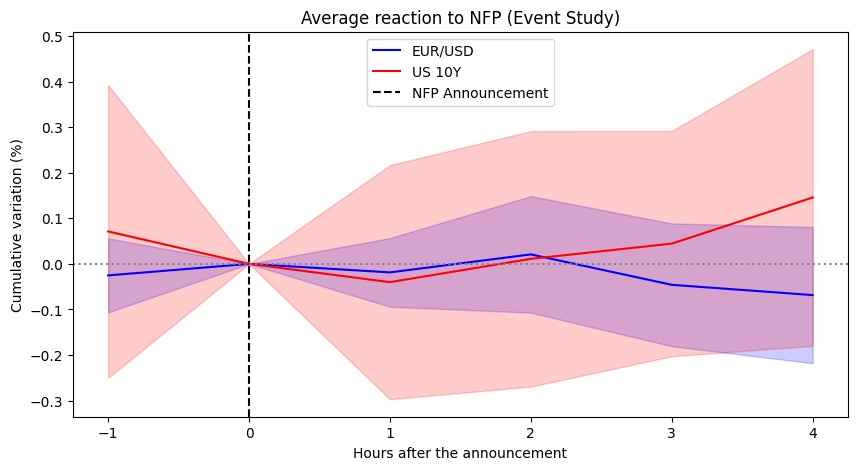

In [61]:
plt.figure(figsize=(10,5))

plt.plot(agg['RelTime'], agg['EURUSD_Mean'], label="EUR/USD", color="blue")
plt.fill_between(agg['RelTime'], agg['EURUSD_LB'], agg['EURUSD_UB'], color="blue", alpha=0.2)

plt.plot(agg['RelTime'], agg['US10Y_Mean'], label="US 10Y", color="red")
plt.fill_between(agg['RelTime'], agg['US10Y_LB'], agg['US10Y_UB'], color="red", alpha=0.2)

plt.axvline(0, color="black", linestyle="--", label="NFP Announcement")
plt.axhline(0, color="grey", linestyle=":")

plt.xlabel("Hours after the announcement")
plt.ylabel("Cumulative variation (%)")
plt.title("Average reaction to NFP (Event Study)")
plt.legend()
plt.show()

**Graphical Interpretation**

- Before the announcement (t = -1h) :

Both assets are stable, showing no clear trend → expected, as the market is awaiting the publication.

- Immediately after the announcement (t = 0 → +1h) :

EUR/USD (blue): slight negative reaction followed by a return close to zero → no strong directional shock.

US 10Y (red): small immediate dip, quickly reversed.

- Between +2h and +4h :

US 10Y rises gradually (≈ +0.15% on average), suggesting upward pressure on yields after the NFP surprise.

EUR/USD remains close to zero with a slight downward bias (≈ -0.05%), showing no strong trend.

- Confidence intervals (shaded areas) :

Wide bands reflect large dispersion across NFP events (some releases trigger strong reactions, others very little).
Despite this uncertainty, the average direction of US yields (upward) is more pronounced than that of EUR/USD.

- Overall :

NFP releases appear to have a clearer and more persistent impact on US yields (US 10Y ↑ after the announcement) than on EUR/USD, whose reaction is weak and highly variable.

**4. Cumulative Returns from Event Onset : Tracking Individual Reactions Over 4 Hours**

In [62]:
df['EURUSD_Return'] = (df['EURUSD_Price'] / df['EURUSD_0'] - 1) * 100
df['US10Y_Return']  = (df['US10Y_Price']  / df['US10Y_0']  - 1) * 100

**EUR/USD**

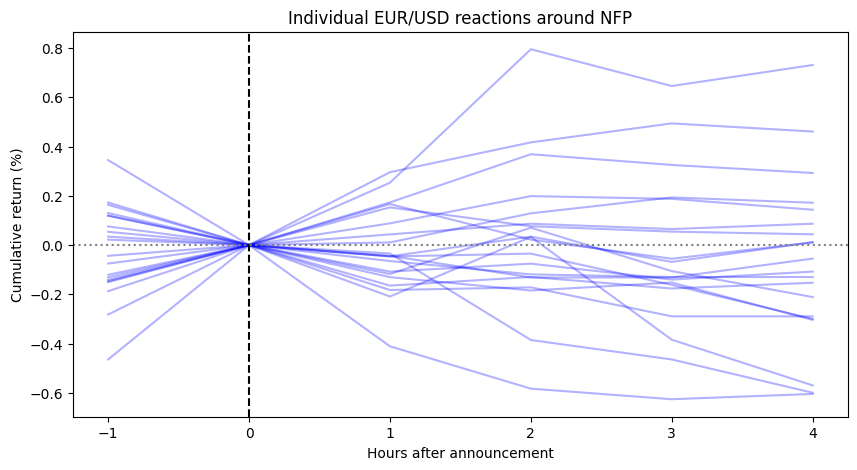

In [63]:
plt.figure(figsize=(10,5))

for event in df['EventDate'].unique():
    subset = df[df['EventDate'] == event]
    plt.plot(subset['RelTime'], subset['EURUSD_Return'], color="blue", alpha=0.3)

plt.axvline(0, color="black", linestyle="--")
plt.axhline(0, color="grey", linestyle=":")
plt.xlabel("Hours after announcement")
plt.ylabel("Cumulative return (%)")
plt.title("Individual EUR/USD reactions around NFP")
plt.show()

**Graphical Interpretation**

- Each line represents a single NFP event.

- High dispersion of reactions: some show increases (+0.8 %), others decreases (≈ -0.6 %).

- No clear directional trend on average → EUR/USD reacts heterogeneously depending on the surprise.

- Conclusion : EUR/USD exhibits no consistent or recurring pattern; responses vary significantly across announcements.

**US 10Y**

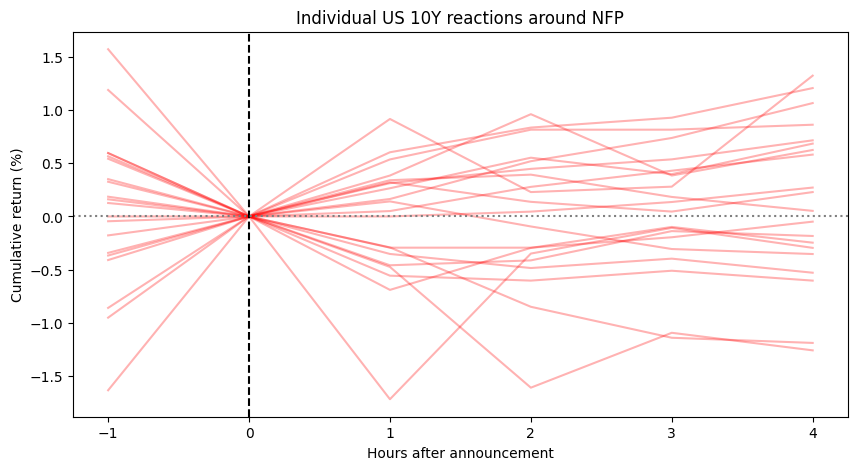

In [64]:
plt.figure(figsize=(10,5))

for event in df['EventDate'].unique():
    subset = df[df['EventDate'] == event]
    plt.plot(subset['RelTime'], subset['US10Y_Return'], color="red", alpha=0.3)

plt.axvline(0, color="black", linestyle="--")
plt.axhline(0, color="grey", linestyle=":")
plt.xlabel("Hours after announcement")
plt.ylabel("Cumulative return (%)")
plt.title("Individual US 10Y reactions around NFP")
plt.show()

**Graphical interpretation**

- Reactions are more pronounced than for EUR/USD (ranging from -1.5% to +1.5%).

- Dispersion is also high, but more persistent movements after the announcement are visible.

- US yields are therefore more sensitive to NFP surprises than EUR/USD.

- Conclusion : The bond market (10Y) reacts more strongly and systematically to NFP releases than the FX market.

**5. Analysis of final changes (0h → +4h)**

In [65]:
final_variation = df[df['RelTime'] == 4][['EventDate','EURUSD_Return','US10Y_Return','Surprise']]
print(final_variation)

     EventDate  EURUSD_Return  US10Y_Return  Surprise
5   2025-09-05      -0.211113     -0.048980    -53000
11  2025-08-01      -0.299751     -0.353698    -33000
17  2025-07-03      -0.152851     -0.183832     36000
23  2025-06-06       0.011390      0.716206     13000
29  2025-05-02      -0.599349      0.863090     39000
35  2025-04-04      -0.569496      1.324842     91000
41  2024-11-01      -0.303486      1.207899    -94000
47  2024-10-04      -0.054854      0.581978    107000
53  2024-09-06       0.011086     -0.295624    -22000
59  2024-08-02       0.043657      0.052448    -62000
65  2024-07-05       0.086642     -0.603820     15000
71  2024-06-07      -0.129701      0.271741     90000
77  2024-05-03      -0.107692     -0.529561    -63000
83  2024-04-05       0.292556      0.229258     91000
89  2023-11-03       0.171824      0.685389    -30000
95  2023-10-06       0.730779     -1.260077    166000
101 2023-09-01      -0.604161      0.625452     17000
107 2023-08-04       0.14341

- EUR/USD :

Average close to zero, with variations between -0.6 % and +0.7 %.
Final reaction is small and dispersed → confirms the absence of a clear pattern.

- US 10Y :

Final changes are more pronounced (up to +1.3 % or down to -1.2 %).
Several strong positive shocks (e.g., 2025-04-04: +1.32 %, 2024-11-01: +1.20 %).
Shows that NFP releases often lead to significant repricing of US yields.

**C - Linking to the Surprise (Grouping reactions by surprise sign) & Formal Statistics (Regressions on EUR/USD and US 10Y)**

**1. Analysis by Surprise Type**

In [66]:
df['SurpriseType'] = df['Surprise'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

In [67]:
agg_type = df.groupby(['RelTime','SurpriseType']).agg(
    EURUSD_Mean=("EURUSD_Return","mean"),
    EURUSD_SE=("EURUSD_Return","sem"),
    US10Y_Mean=("US10Y_Return","mean"),
    US10Y_SE=("US10Y_Return","sem")
).reset_index()

agg_type['EURUSD_LB'] = agg_type['EURUSD_Mean'] - 1.96*agg_type['EURUSD_SE']
agg_type['EURUSD_UB'] = agg_type['EURUSD_Mean'] + 1.96*agg_type['EURUSD_SE']
agg_type['US10Y_LB']  = agg_type['US10Y_Mean']  - 1.96*agg_type['US10Y_SE']
agg_type['US10Y_UB']  = agg_type['US10Y_Mean']  + 1.96*agg_type['US10Y_SE']

- Events are split into Positive vs Negative surprises.

- Average trajectories of EUR/USD and US 10Y are computed for each category.

- 95% confidence intervals allow to assess the dispersion of reactions across events.

- This sets up a formal comparison of market responses depending on the sign of the NFP surprise.

**2. EUR/USD Visualisation**

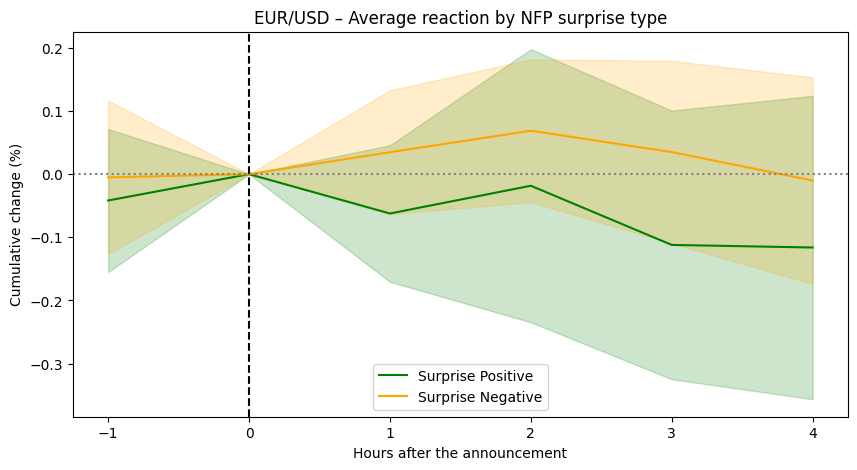

In [68]:
plt.figure(figsize=(10,5))

for s_type, color in zip(['Positive','Negative'], ['green','orange']):
    subset = agg_type[agg_type['SurpriseType']==s_type]
    plt.plot(subset['RelTime'], subset['EURUSD_Mean'], label=f"Surprise {s_type}", color=color)
    plt.fill_between(subset['RelTime'], subset['EURUSD_LB'], subset['EURUSD_UB'], color=color, alpha=0.2)

plt.axvline(0, color="black", linestyle="--")
plt.axhline(0, color="grey", linestyle=":")
plt.xlabel("Hours after the announcement")
plt.ylabel("Cumulative change (%)")
plt.title("EUR/USD – Average reaction by NFP surprise type")
plt.legend()
plt.show()

**Graphical Interpretation**

- Positive surprise (green) : Slight downward trend after the announcement, but small in magnitude (≈ -0.1% at +4h).

- Negative surprise (orange) : Small upward movement after the announcement, around +0.1% at +3h.

- Confidence intervals overlap considerably → the signal is weak and not statistically significant.

- Conclusion : EUR/USD reacts in the expected direction (better US employment → stronger USD → EUR/USD falls) but the effect is minor and lost in overall variability.

**3. US 10Y Visualisation**

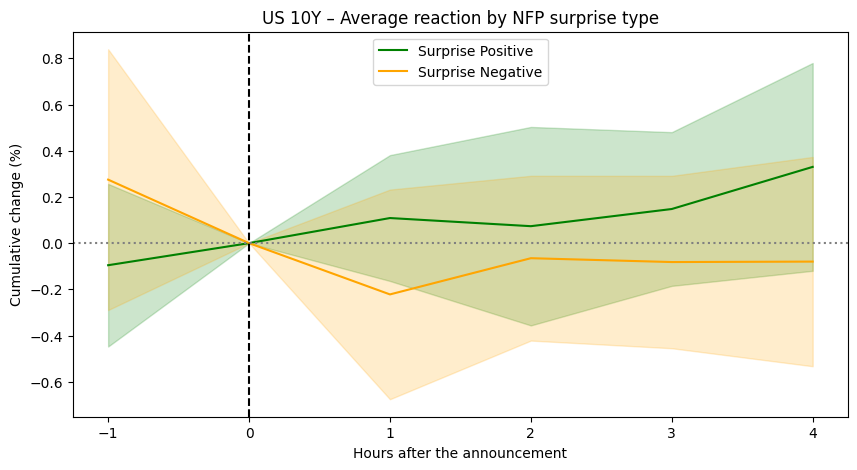

In [69]:
plt.figure(figsize=(10,5))

for s_type, color in zip(['Positive','Negative'], ['green','orange']):
    subset = agg_type[agg_type['SurpriseType']==s_type]
    plt.plot(subset['RelTime'], subset['US10Y_Mean'], label=f"Surprise {s_type}", color=color)
    plt.fill_between(subset['RelTime'], subset['US10Y_LB'], subset['US10Y_UB'], color=color, alpha=0.2)

plt.axvline(0, color="black", linestyle="--")
plt.axhline(0, color="grey", linestyle=":")
plt.xlabel("Hours after the announcement")
plt.ylabel("Cumulative change (%)")
plt.title("US 10Y – Average reaction by NFP surprise type")
plt.legend()
plt.show()

**Graphical Interpretation**

- Positive surprise (green) : clear and gradual rise in yields (≈ +0.3 % at +4h).

- Negative surprise (orange) : opposite trend, moderate decline (≈ -0.2 % at +2h, then stabilization).

- Confidence bands are wide, but the symmetry between the two types of surprises is evident.

**4. Modeling Market Reactions – Linking Macroeconomic Surprises to Asset Returns**

Using the OLS Model (Ordinary Least Squares) :

We aim to estimate a simple linear relationship between the NFP surprise (explanatory variable) and the price change (0 → +4h) (dependent variable). OLS is the standard tool to measure this sensitivity.

Main goal :

Quantify whether, on average, a +100k jobs surprise significantly moves the EUR/USD or US yields, and by how much.

Why significant here ?

NFP represents a major macroeconomic shock → we expect a direct relationship with the USD and yields.
OLS allows us to statistically test (p-value) whether this intuition is supported by the data or if the observed reactions are just noise.


In short :

OLS is used here to measure and test economic causality (surprise → price).

In [70]:
reg_data = final_variation.copy()

y_eurusd = reg_data['EURUSD_Return']
y_us10y  = reg_data['US10Y_Return']

X = sm.add_constant(reg_data['Surprise'])

**EUR/USD Regression Analysis**

In [71]:
model_eurusd = sm.OLS(y_eurusd, X).fit()
print(model_eurusd.summary())

                            OLS Regression Results                            
Dep. Variable:          EURUSD_Return   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.3217
Date:                Mon, 20 Oct 2025   Prob (F-statistic):              0.578
Time:                        15:19:21   Log-Likelihood:                -6.1808
No. Observations:                  20   AIC:                             16.36
Df Residuals:                      18   BIC:                             18.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0818      0.081     -1.008      0.3

**Analysis of Results**

**Interpreting the coefficients :**

- Intercept (α = -0.0818) : On average, without any particular surprise, EUR/USD slightly decreases (-0.08%), but this effect is not statistically significant (p = 0.327). The 95% confidence interval [-0.252 ; 0.089] includes zero, confirming the absence of any systematic drift.

- Surprise coefficient (β ≈ 6.1e-07) : Positive sign → a positive surprise (e.g., stronger macro data) would slightly increase EUR/USD. Economically, we might expect the opposite (better US data → stronger USD → lower EUR/USD). This suggests that the estimated relationship is not robust nor economically meaningful.

**Statistical significance :**

- P-value (0.578) : Well above 0.05 → the “Surprise” variable has no statistically significant effect on EUR/USD returns.

- R² (0.018) : The model explains only 1.8% of the variation, i.e. almost nothing.

- F-statistic (0.32, p = 0.578) : Confirms the lack of overall significance.

**Conclusion :**

- EUR/USD returns do not react systematically to surprises in this sample; the observed fluctuations are mainly market noise.

- The regression confirms the absence of a linear link between the “Surprise” variable and exchange rate movements — consistent with the idea that FX markets quickly price in expectations or react to other concurrent factors.


**US 10Y Regression Analysis**

In [72]:
model_us10y = sm.OLS(y_us10y, X).fit()
print(model_us10y.summary())

                            OLS Regression Results                            
Dep. Variable:           US10Y_Return   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.1613
Date:                Mon, 20 Oct 2025   Prob (F-statistic):              0.693
Time:                        15:19:21   Log-Likelihood:                -21.821
No. Observations:                  20   AIC:                             47.64
Df Residuals:                      18   BIC:                             49.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1250      0.177      0.705      0.4

**Analysis of Results :**

**Interpreting the coefficients :**

- Intercept (α = 0.1250) : On average, when there is no surprise, the US 10-year yield return is slightly positive (+0.125%), but this effect is not statistically significant (p = 0.490). The 95% confidence interval [−0.248;0.498] includes zero, confirming the absence of any systematic bias in average returns.

- Surprise coefficient (β ≈ 9.4e-07) : Positive sign → a positive “Surprise” would be associated with a very small increase in US10Y_Return.
However, the magnitude is economically negligible, and the relationship is not statistically significant. This suggests that “Surprise” has no meaningful effect on 10-year yield returns in this sample.

**Statistical significance :**
- P-value (0.693) : Far above 0.05 → the “Surprise” variable has no statistically significant effect on US10Y_Return.
- R² (0.009): The model explains less than 1% of the variation in returns — essentially none.
- F-statistic (0.16, p = 0.693) : Confirms the overall lack of explanatory power of the model.

**Conclusion :**

US 10-year yield returns do not respond systematically to surprises in this dataset.

The observed fluctuations appear to be pure market noise, with no discernible linear relationship between the “Surprise” variable and bond returns.
This result is consistent with the idea that the Treasury market efficiently incorporates expectations and reacts primarily to other contemporaneous factors.

**D - Discussion & Opening**

**1. Study Limitations**

- Sample size : The analysis covers 27 complete NFP releases (≈ 2 years of data). This small sample limits the statistical power of the regressions (only 20 full observations) and prevents identifying robust relationships.

- Data granularity : With hourly frequency, some fine intraday dynamics (market reactions in the minutes following the release) may be diluted.

- Choice of assets : Only EUR/USD and the US 10Y yield were studied. NFP surprises also affect other markets (equity indices, the full yield curve, USD index).

**2. Potential Improvements**

- Expand the historical horizon : Including several additional years of NFP releases (10–15 years) would considerably increase the sample size and improve statistical significance.

- Increase data frequency : Using 5-minute or 1-minute data would better capture immediate NFP reactions and identify the market adjustment speed.

- Diversify assets : Extend the study to other NFP-sensitive assets :

FX _ Dollar Index (DXY), USD/JPY

Yields _ Other maturities (2Y, 30Y) to compare curve reactions

Equities _ S&P500, equity futures

- Advanced econometric methods : Test alternative approaches such as quantile regressions, VAR (Vector AutoRegressions) or panel event studies.

**3. Practical Scope**

Even if current results are not statistically significant, the approach demonstrates a replicable desk methodology :

- Structure a macro hypothesis (NFP → USD/Yields).

- Extract and clean market data.

- Quickly test empirical relationships using a rigorous framework.

- Communicate results clearly, visually and with interpretation.

**STEP 4 _ EVENT STUDY CONCLUSION**

This event study aimed to analyze the impact of U.S. employment releases (Non-Farm Payrolls, NFP) on two major assets : EUR/USD and the U.S. 10-year sovereign yield.

**A - Preparation & Methodology**

- Constructed windows [-1h ; +4h] around each NFP release.

- Calculated cumulative changes relative to the announcement time (t = 0).

- Aggregated by type of surprise (positive vs. negative).

- Estimated statistical relationships using OLS models to quantify price sensitivity to surprises.

**B - Empirical Results**

- EUR/USD : Highly dispersed reactions, with no clear trend. Regressions show no significant link between NFP surprises and FX movements → effect lost in market noise.

- U.S. 10Y yield : More pronounced and directional reactions (rise after a positive surprise, decline after a negative one). However, with a limited sample (27 events and 20 full observations over 2 years), the relationship is not statistically significant.

**C - Key Insights**

- NFP releases remain an important market catalyst, but their effect is stronger on U.S. yields than on currencies.

- The study illustrates the limitations of a small sample : reaction dispersion dominates the signals.

- Methodologically, the framework is replicable and extensible : with more historical data, statistical significance should improve.

**D - Skills Highlighted**

- Financial data handling and cleaning (pandas).

- Event study design and temporal window setup

- Statistical analysis and modeling (statsmodels OLS).

- Clear visualization (matplotlib) and economic interpretation.

**E - Final Conclusion**


- This analysis demonstrates my ability to process market data, structure a quantitative methodology and draw rigorous conclusions while highlighting empirical limitations.

- In a professional setting (Sales & Trading), this approach can be directly applied to quickly test market hypotheses and support decision-making.